# 1) IMPORTING LIBRARIES AND PACKAGES

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import pickle
from sklearn import model_selection
# from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
# from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from xgboost import XGBClassifier, XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score,r2_score,mean_absolute_error,mean_squared_error,accuracy_score,classification_report,confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import shap
from sklearn.neural_network import MLPRegressor
import model_utils

# 2) DATASET IMPORTING

In [3]:
data = pd.read_csv('Data/DataCoSupplyChainDataset.csv',header= 0,encoding='unicode_escape')
pd.set_option('display.max_columns',None)
data.head()

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,Customer Country,Customer Email,Customer Fname,Customer Id,Customer Lname,Customer Password,Customer Segment,Customer State,Customer Street,Customer Zipcode,Department Id,Department Name,Latitude,Longitude,Market,Order City,Order Country,Order Customer Id,order date (DateOrders),Order Id,Order Item Cardprod Id,Order Item Discount,Order Item Discount Rate,Order Item Id,Order Item Product Price,Order Item Profit Ratio,Order Item Quantity,Sales,Order Item Total,Order Profit Per Order,Order Region,Order State,Order Status,Order Zipcode,Product Card Id,Product Category Id,Product Description,Product Image,Product Name,Product Price,Product Status,shipping date (DateOrders),Shipping Mode
0,DEBIT,3,4,91.250000,314.640015,Advance shipping,0,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Cally,20755,Holloway,XXXXXXXXX,Consumer,PR,5365 Noble Nectar Island,725.0,2,Fitness,18.251453,-66.037056,Pacific Asia,Bekasi,Indonesia,20755,1/31/2018 22:56,77202,1360,13.110000,0.04,180517,327.75,0.29,1,327.75,314.640015,91.250000,Southeast Asia,Java Occidental,COMPLETE,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,2/3/2018 22:56,Standard Class
1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,1,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Irene,19492,Luna,XXXXXXXXX,Consumer,PR,2679 Rustic Loop,725.0,2,Fitness,18.279451,-66.037064,Pacific Asia,Bikaner,India,19492,1/13/2018 12:27,75939,1360,16.389999,0.05,179254,327.75,-0.80,1,327.75,311.359985,-249.089996,South Asia,Rajastán,PENDING,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/18/2018 12:27,Standard Class
2,CASH,4,4,-247.779999,309.720001,Shipping on time,0,73,Sporting Goods,San Jose,EE. UU.,XXXXXXXXX,Gillian,19491,Maldonado,XXXXXXXXX,Consumer,CA,8510 Round Bear Gate,95125.0,2,Fitness,37.292233,-121.881279,Pacific Asia,Bikaner,India,19491,1/13/2018 12:06,75938,1360,18.030001,0.06,179253,327.75,-0.80,1,327.75,309.720001,-247.779999,South Asia,Rajastán,CLOSED,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/17/2018 12:06,Standard Class
3,DEBIT,3,4,22.860001,304.809998,Advance shipping,0,73,Sporting Goods,Los Angeles,EE. UU.,XXXXXXXXX,Tana,19490,Tate,XXXXXXXXX,Home Office,CA,3200 Amber Bend,90027.0,2,Fitness,34.125946,-118.291016,Pacific Asia,Townsville,Australia,19490,1/13/2018 11:45,75937,1360,22.940001,0.07,179252,327.75,0.08,1,327.75,304.809998,22.860001,Oceania,Queensland,COMPLETE,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/16/2018 11:45,Standard Class
4,PAYMENT,2,4,134.210007,298.250000,Advance shipping,0,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Orli,19489,Hendricks,XXXXXXXXX,Corporate,PR,8671 Iron Anchor Corners,725.0,2,Fitness,18.253769,-66.037048,Pacific Asia,Townsville,Australia,19489,1/13/2018 11:24,75936,1360,29.500000,0.09,179251,327.75,0.45,1,327.75,298.250000,134.210007,Oceania,Queensland,PENDING_PAYMENT,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/15/2018 11:24,Standard Class


# 3) EDA (low-level)

In [4]:
filtered_df = data[data['Order Status'].isin(['CANCELED', 'SUSPECTED_FRAUD'])]

# Get the unique values in the 'late delivery risk' column
unique_late_delivery_risks = filtered_df['Late_delivery_risk'].unique()

# Print the unique values
print(unique_late_delivery_risks)

# Canceled and suspected fraud orders are always non-late deliveries, so not useful for the model

[0]


In [5]:
# CHECK IF EVERY ORDER ID HAS SAME ORDER STATUS
grouped_order = data.groupby('Order Id')
print(len(grouped_order))
grouped = data.groupby('Order Id')['Order Status'].nunique()

# Check if each order_id has only one unique 'order_status'
print(grouped == 1)
print(len(grouped == 1))
print(len(grouped))

65752
Order Id
1        True
2        True
4        True
5        True
7        True
         ... 
77200    True
77201    True
77202    True
77203    True
77204    True
Name: Order Status, Length: 65752, dtype: bool
65752
65752


Conclusion: every row represents an ordered item delivery, which can be part of an order delivery. Please note that every order item (=row) belonging to the same order (same order id) has the same order status every time. Thus, for our ML tasks, we will construct one row for each order, containing the information of the customer, the delivery..., and the products belonging to that order (instead of having one row per product as in the original data).

In [6]:
def data_info(data):
    print('1) Number of columns are : ',data.shape[1])
    print('2) Number of rows are : ',data.shape[0])
    print('3) Total number of data-points :',data.size)
    numerical_features = [f for f in data.columns if data[f].dtypes!='O']
    print('4) Count of Numerical Features :',len(numerical_features))
    cat_features = [c for c in data.columns if data[c].dtypes=='O']
    print('5) Count of Categorical Features :',len(cat_features))
data_info(data)

1) Number of columns are :  53
2) Number of rows are :  180519
3) Total number of data-points : 9567507
4) Count of Numerical Features : 29
5) Count of Categorical Features : 24


In [7]:
def features_with_missing_values(data):
    x = data.isnull().sum().sum()/(data.shape[0]*data.shape[1])*100
    print('Percentage of Total Missing Values is ' ,round(x,2) ,'%')
    print('Missing Value Estimation :')
    for i in data.columns:
        if data[i].isna().sum()>0:
            print('The Feature ',i,' has '+ str(data[i].isna().sum()) + ' missing values')
            
features_with_missing_values(data)
# no useful features with missing values

Percentage of Total Missing Values is  3.51 %
Missing Value Estimation :
The Feature  Customer Lname  has 8 missing values
The Feature  Customer Zipcode  has 3 missing values
The Feature  Order Zipcode  has 155679 missing values
The Feature  Product Description  has 180519 missing values


# 4) FEATURE ENGINEERING

In [8]:
#Converting categorical features that represent date and time to datetime datatype.
data['order_date'] = pd.to_datetime(data['order date (DateOrders)'])

In [9]:
# Handling Time and date variables
data['order_year'] = pd.DatetimeIndex(data['order_date']).year
data['order_month'] = pd.DatetimeIndex(data['order_date']).month
data['order_day'] = pd.DatetimeIndex(data['order_date']).day

In [10]:
# Check percentage late_delivery_risk vs non_late_delivery_risk
late_delivery_risk = data['Late_delivery_risk'].value_counts()
print(late_delivery_risk)
print('Percentage of Late Delivery Risk :',round(late_delivery_risk[1]/data.shape[0]*100,2))
perc_late_delivery_risk = round(late_delivery_risk[1]/data.shape[0]*100,2)

Late_delivery_risk
1    98977
0    81542
Name: count, dtype: int64
Percentage of Late Delivery Risk : 54.83


In [11]:
# Note that we don't take shipping date into account because it is not available at the time of prediction (shipping date - order date = days for shipping)
new_dataset_features = ['Type', 'Late_delivery_risk','Benefit per order', 'Days for shipping (real)', 'Days for shipment (scheduled)',
                        'Latitude','Longitude','Shipping Mode','Order Status',
                        'Order Country', 'order_day','order_month','order_year',
                        'Product Name', 'Order Id', 'Market']
len(new_dataset_features)

16

In [12]:
new_data = data[new_dataset_features]
statuses_to_drop = ['CANCELED', 'SUSPECTED_FRAUD']
# Drop rows where late delivery risk is always 0 (when the order status is 'CANCELED' or 'SUSPECTED_FRAUD')
model_data = new_data[~new_data['Order Status'].isin(statuses_to_drop)]
# Drop rows where 'Order Status' is in the list of statuses to drop
model_data.head()

,Type,Late_delivery_risk,Benefit per order,Days for shipping (real),Days for shipment (scheduled),Latitude,Longitude,Shipping Mode,Order Status,Order Country,order_day,order_month,order_year,Product Name,Order Id,Market
0,DEBIT,0,91.250000,3,4,18.251453,-66.037056,Standard Class,COMPLETE,Indonesia,31,1,2018,Smart watch,77202,Pacific Asia
1,TRANSFER,1,-249.089996,5,4,18.279451,-66.037064,Standard Class,PENDING,India,13,1,2018,Smart watch,75939,Pacific Asia
2,CASH,0,-247.779999,4,4,37.292233,-121.881279,Standard Class,CLOSED,India,13,1,2018,Smart watch,75938,Pacific Asia
3,DEBIT,0,22.860001,3,4,34.125946,-118.291016,Standard Class,COMPLETE,Australia,13,1,2018,Smart watch,75937,Pacific Asia
4,PAYMENT,0,134.210007,2,4,18.253769,-66.037048,Standard Class,PENDING_PAYMENT,Australia,13,1,2018,Smart watch,75936,Pacific Asia


In [13]:
#One-Hot encoding categotical variables in the data
model_data = pd.get_dummies(model_data)
model_data.shape
model_data

,Late_delivery_risk,Benefit per order,Days for shipping (real),Days for shipment (scheduled),Latitude,Longitude,order_day,order_month,order_year,Order Id,Type_CASH,Type_DEBIT,Type_PAYMENT,Type_TRANSFER,Shipping Mode_First Class,Shipping Mode_Same Day,Shipping Mode_Second Class,Shipping Mode_Standard Class,Order Status_CLOSED,Order Status_COMPLETE,Order Status_ON_HOLD,Order Status_PAYMENT_REVIEW,Order Status_PENDING,Order Status_PENDING_PAYMENT,Order Status_PROCESSING,Order Country_Afganistán,Order Country_Albania,Order Country_Alemania,Order Country_Angola,Order Country_Arabia Saudí,Order Country_Argelia,Order Country_Argentina,Order Country_Armenia,Order Country_Australia,Order Country_Austria,Order Country_Azerbaiyán,Order Country_Bangladés,Order Country_Barbados,Order Country_Baréin,Order Country_Belice,Order Country_Benín,Order Country_Bielorrusia,Order Country_Bolivia,Order Country_Bosnia y Herzegovina,Order Country_Botsuana,Order Country_Brasil,Order Country_Bulgaria,Order Country_Burkina Faso,Order Country_Burundi,Order Country_Bután,Order Country_Bélgica,Order Country_Camboya,Order Country_Camerún,Order Country_Canada,Order Country_Chad,Order Country_Chile,Order Country_China,Order Country_Chipre,Order Country_Colombia,Order Country_Corea del Sur,Order Country_Costa Rica,Order Country_Costa de Marfil,Order Country_Croacia,Order Country_Cuba,Order Country_Dinamarca,Order Country_Ecuador,Order Country_Egipto,Order Country_El Salvador,Order Country_Emiratos Árabes Unidos,Order Country_Eritrea,Order Country_Eslovaquia,Order Country_Eslovenia,Order Country_España,Order Country_Estados Unidos,Order Country_Estonia,Order Country_Etiopía,Order Country_Filipinas,Order Country_Finlandia,Order Country_Francia,Order Country_Gabón,Order Country_Georgia,Order Country_Ghana,Order Country_Grecia,Order Country_Guadalupe,Order Country_Guatemala,Order Country_Guayana Francesa,Order Country_Guinea,Order Country_Guinea Ecuatorial,Order Country_Guinea-Bissau,Order Country_Guyana,Order Country_Haití,Order Country_Honduras,Order Country_Hong Kong,Order Country_Hungría,Order Country_India,Order Country_Indonesia,Order Country_Irak,Order Country_Irlanda,Order Country_Irán,Order Country_Israel,Order Country_Italia,Order Country_Jamaica,Order Country_Japón,Order Country_Jordania,Order Country_Kazajistán,Order Country_Kenia,Order Country_Kirguistán,Order Country_Kuwait,Order Country_Laos,Order Country_Lesoto,Order Country_Liberia,Order Country_Libia,Order Country_Lituania,Order Country_Luxemburgo,Order Country_Líbano,Order Country_Macedonia,Order Country_Madagascar,Order Country_Malasia,Order Country_Mali,Order Country_Marruecos,Order Country_Martinica,Order Country_Mauritania,Order Country_Moldavia,Order Country_Mongolia,Order Country_Montenegro,Order Country_Mozambique,Order Country_Myanmar (Birmania),Order Country_México,Order Country_Namibia,Order Country_Nepal,Order Country_Nicaragua,Order Country_Nigeria,Order Country_Noruega,Order Country_Nueva Zelanda,Order Country_Níger,Order Country_Omán,Order Country_Pakistán,Order Country_Panamá,Order Country_Papúa Nueva Guinea,Order Country_Paraguay,Order Country_Países Bajos,Order Country_Perú,Order Country_Polonia,Order Country_Portugal,Order Country_Qatar,Order Country_Reino Unido,Order Country_República Centroafricana,Order Country_República Checa,Order Country_República Democrática del Congo,Order Country_República Dominicana,Order Country_República de Gambia,Order Country_República del Congo,Order Country_Ruanda,Order Country_Rumania,Order Country_Rusia,Order Country_Senegal,Order Country_Serbia,Order Country_Sierra Leona,Order Country_Singapur,Order Country_Siria,Order Country_Somalia,Order Country_Sri Lanka,Order Country_Suazilandia,Order Country_SudAfrica,Order Country_Sudán,Order Country_Sudán del Sur,Order Country_Suecia,Order Country_Suiza,Order Country_Surinam,Order Country_Sáhara Occidental,Order Country_Tailandia,Order Country_Taiwán,Order Country_Tanzania,Order Country_Tayikistán,Order

In [14]:
# Make one row per order, with a column for each product and the profit for that product (instead of multiple rows per order, split by product)

product_columns = [col for col in model_data.columns if col.startswith('Product Name_')]
unpivot_columns = product_columns
# Melt the dataframe to long format, excluding profit from id_vars
df_melted = model_data.melt(id_vars=['Order Id', 'Benefit per order'], value_vars=unpivot_columns,var_name='Product', value_name='is_in_order')
# Filter out rows where the product is not in the order
df_filtered = df_melted[df_melted['is_in_order'] == True]
# # Create a profit column for each product
df_filtered['Product'] = df_filtered['Product'].str.replace('Product Name_', 'Profit on ')
# # Pivot the dataframe to get the desired format
df_pivot = df_filtered.pivot_table(index='Order Id', columns='Product', values='Benefit per order', aggfunc='first')
# # Reset index to turn order_id back into a column
result_df = df_pivot.reset_index()
# # Fill NaN values with 0 (optional, if you prefer to have 0 instead of NaN)
result_df = result_df.fillna(0)
# # Drop column "Product Name" and "Benefit per order"
columns_to_drop = list(model_data.filter(like='Product Name_').columns) + ['Benefit per order']
df_cleaned = model_data.drop(columns=columns_to_drop)
# # Grab the first row for each order_id
df1_first_row = df_cleaned.groupby('Order Id').head(1)
# # Merge the two dataframes
result = pd.merge(df1_first_row, result_df, on='Order Id', how='left')
result = result.fillna(0)
# # Drop the 'Order Id' column
prep_data = result.drop(columns=['Order Id'])
prep_data

,Late_delivery_risk,Days for shipping (real),Days for shipment (scheduled),Latitude,Longitude,order_day,order_month,order_year,Type_CASH,Type_DEBIT,Type_PAYMENT,Type_TRANSFER,Shipping Mode_First Class,Shipping Mode_Same Day,Shipping Mode_Second Class,Shipping Mode_Standard Class,Order Status_CLOSED,Order Status_COMPLETE,Order Status_ON_HOLD,Order Status_PAYMENT_REVIEW,Order Status_PENDING,Order Status_PENDING_PAYMENT,Order Status_PROCESSING,Order Country_Afganistán,Order Country_Albania,Order Country_Alemania,Order Country_Angola,Order Country_Arabia Saudí,Order Country_Argelia,Order Country_Argentina,Order Country_Armenia,Order Country_Australia,Order Country_Austria,Order Country_Azerbaiyán,Order Country_Bangladés,Order Country_Barbados,Order Country_Baréin,Order Country_Belice,Order Country_Benín,Order Country_Bielorrusia,Order Country_Bolivia,Order Country_Bosnia y Herzegovina,Order Country_Botsuana,Order Country_Brasil,Order Country_Bulgaria,Order Country_Burkina Faso,Order Country_Burundi,Order Country_Bután,Order Country_Bélgica,Order Country_Camboya,Order Country_Camerún,Order Country_Canada,Order Country_Chad,Order Country_Chile,Order Country_China,Order Country_Chipre,Order Country_Colombia,Order Country_Corea del Sur,Order Country_Costa Rica,Order Country_Costa de Marfil,Order Country_Croacia,Order Country_Cuba,Order Country_Dinamarca,Order Country_Ecuador,Order Country_Egipto,Order Country_El Salvador,Order Country_Emiratos Árabes Unidos,Order Country_Eritrea,Order Country_Eslovaquia,Order Country_Eslovenia,Order Country_España,Order Country_Estados Unidos,Order Country_Estonia,Order Country_Etiopía,Order Country_Filipinas,Order Country_Finlandia,Order Country_Francia,Order Country_Gabón,Order Country_Georgia,Order Country_Ghana,Order Country_Grecia,Order Country_Guadalupe,Order Country_Guatemala,Order Country_Guayana Francesa,Order Country_Guinea,Order Country_Guinea Ecuatorial,Order Country_Guinea-Bissau,Order Country_Guyana,Order Country_Haití,Order Country_Honduras,Order Country_Hong Kong,Order Country_Hungría,Order Country_India,Order Country_Indonesia,Order Country_Irak,Order Country_Irlanda,Order Country_Irán,Order Country_Israel,Order Country_Italia,Order Country_Jamaica,Order Country_Japón,Order Country_Jordania,Order Country_Kazajistán,Order Country_Kenia,Order Country_Kirguistán,Order Country_Kuwait,Order Country_Laos,Order Country_Lesoto,Order Country_Liberia,Order Country_Libia,Order Country_Lituania,Order Country_Luxemburgo,Order Country_Líbano,Order Country_Macedonia,Order Country_Madagascar,Order Country_Malasia,Order Country_Mali,Order Country_Marruecos,Order Country_Martinica,Order Country_Mauritania,Order Country_Moldavia,Order Country_Mongolia,Order Country_Montenegro,Order Country_Mozambique,Order Country_Myanmar (Birmania),Order Country_México,Order Country_Namibia,Order Country_Nepal,Order Country_Nicaragua,Order Country_Nigeria,Order Country_Noruega,Order Country_Nueva Zelanda,Order Country_Níger,Order Country_Omán,Order Country_Pakistán,Order Country_Panamá,Order Country_Papúa Nueva Guinea,Order Country_Paraguay,Order Country_Países Bajos,Order Country_Perú,Order Country_Polonia,Order Country_Portugal,Order Country_Qatar,Order Country_Reino Unido,Order Country_República Centroafricana,Order Country_República Checa,Order Country_República Democrática del Congo,Order Country_República Dominicana,Order Country_República de Gambia,Order Country_República del Congo,Order Country_Ruanda,Order Country_Rumania,Order Country_Rusia,Order Country_Senegal,Order Country_Serbia,Order Country_Sierra Leona,Order Country_Singapur,Order Country_Siria,Order Country_Somalia,Order Country_Sri Lanka,Order Country_Suazilandia,Order Country_SudAfrica,Order Country_Sudán,Order Country_Sudán del Sur,Order Country_Suecia,Order Country_Suiza,Order Country_Surinam,Order Country_Sáhara Occidental,Order Country_Tailandia,Order Country_Taiwán,Order Country_Tanzania,Order Country_Tayikistán,Order Country_Togo,Order Country

# 5) Classification

In [15]:
x_class = prep_data.drop(['Late_delivery_risk', 'Days for shipping (real)'],axis=1)
y_class = prep_data[['Late_delivery_risk']]
# train-test_split
x_train_class,x_test_class,y_train_class,y_test_class = model_selection.train_test_split(x_class,y_class,test_size=0.20,random_state=42,stratify=y_class)

dt_classifier_pipeline trained
lr_classifier_pipeline trained
xgb_classifier_pipeline trained
Accuracy for dt_classifier_pipeline: 0.6273449920508744
ROC for dt_classifier_pipeline: 0.6189608370331916
Report for dt_classifier_pipeline:               precision    recall  f1-score   support

           0       0.56      0.56      0.56      5370
           1       0.67      0.68      0.68      7210

    accuracy                           0.63     12580
   macro avg       0.62      0.62      0.62     12580
weighted avg       0.63      0.63      0.63     12580

Accuracy for lr_classifier_pipeline: 0.6970588235294117
ROC for lr_classifier_pipeline: 0.720126582932354
Report for lr_classifier_pipeline:               precision    recall  f1-score   support

           0       0.60      0.88      0.71      5370
           1       0.86      0.56      0.68      7210

    accuracy                           0.70     12580
   macro avg       0.73      0.72      0.70     12580
weighted avg       0.75 

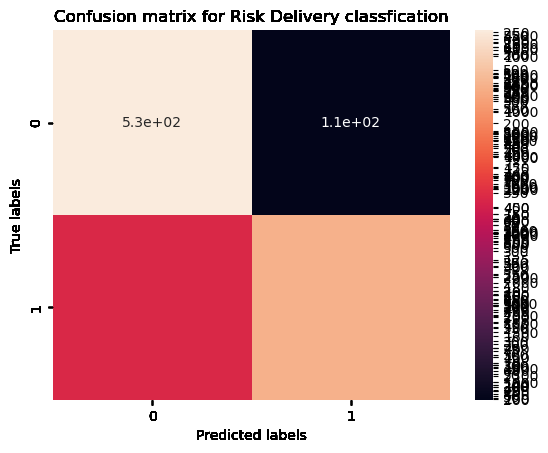

In [16]:
# Initialize models
models = model_utils.init_models(type='classification')
# Train models
model_utils.train_models(models, x_train_class, y_train_class)
# Evaluate models
preds = model_utils.predict(models, x_test_class)
acc,roc,rep = model_utils.eval_classification(y_true=y_test_class,preds=preds)
# Evaluate per order status
acc,roc,rep = model_utils.eval_per_order_status(x=x_test_class,y=y_test_class,models=models, type='classification')

# 5) Classification only important features

In [17]:
importance_df = model_utils.get_ft_importance(x=x_train_class,model=models["xgb_classifier_pipeline"], type='classification')
importance_df

,Feature,Importance
0,Days for shipment (scheduled),0.441334
10,Shipping Mode_First Class,0.172936
12,Shipping Mode_Second Class,0.056673
162,Order Country_Suecia,0.005163
72,Order Country_Filipinas,0.005115
...,...,...
125,Order Country_Nepal,0.000000
131,Order Country_Omán,0.000000
134,Order Country_Papúa Nueva Guinea,0.000000
136,Order Country_Países Bajos,0.000000


In [19]:
# Let's drop Order City, Order Country, and Order Region as they have minimal importance compared to their dimensionality (Scheduled and shipping mode are definitely important)
features = ['^Market','^Type','^Latitude','^Longitude','^Order Status','^order_','^Profit on']
# These are the features we will drop/keep depending on the performance of the model. We will definitely keep Shipping Mode, as it has the highest importance score
features_to_drop = ['^Order City_', '^Order Country_', '^Order Region_']
ft_performace_dict = model_utils.get_best_fts(models=models,prep_data=prep_data,features=features, features_to_drop=features_to_drop, type='classification')
ft_performace_dict

Model: dt_classifier_pipeline
Combination: ('^Market',)
Performance: 0.6210305622493072


Model: dt_classifier_pipeline
Combination: ('^Type',)
Performance: 0.6203254583820836


Model: dt_classifier_pipeline
Combination: ('^Latitude',)
Performance: 0.6151762630528156


Model: dt_classifier_pipeline
Combination: ('^Longitude',)
Performance: 0.6140536498810621


Model: dt_classifier_pipeline
Combination: ('^Order Status',)
Performance: 0.6246546153309727


Model: dt_classifier_pipeline
Combination: ('^order_',)
Performance: 0.6180607319133109


Model: dt_classifier_pipeline
Combination: ('^Profit on',)
Performance: 0.6111133925827206


Model: dt_classifier_pipeline
Combination: ('^Market', '^Type')
Performance: 0.6222492555084626


Model: dt_classifier_pipeline
Combination: ('^Market', '^Latitude')
Performance: 0.6207857129943153


Model: dt_classifier_pipeline
Combination: ('^Market', '^Longitude')
Performance: 0.6145725340089934


Model: dt_classifier_pipeline
Combination: ('^Market', 

{'dt_classifier_pipeline': {('^Market',
   '^Type',
   '^Latitude',
   '^Longitude',
   '^Order Status',
   '^order_',
   '^Profit on'): 0.7287347905479923,
  ('^Market',
   '^Latitude',
   '^Longitude',
   '^order_',
   '^Profit on'): 0.7281548232462156,
  ('^Market',
   '^Type',
   '^Latitude',
   '^Longitude',
   '^order_',
   '^Profit on'): 0.7281548232462156,
  ('^Market',
   '^Latitude',
   '^Longitude',
   '^Order Status',
   '^order_',
   '^Profit on'): 0.7281548232462156,
  ('^Type',
   '^Latitude',
   '^Longitude',
   '^Order Status',
   '^order_',
   '^Profit on'): 0.7280127693535515,
  ('^Latitude',
   '^Longitude',
   '^Order Status',
   '^order_',
   '^Profit on'): 0.7267863277002509,
  ('^Latitude', '^Longitude', '^order_', '^Profit on'): 0.7249741074495644,
  ('^Type',
   '^Latitude',
   '^Longitude',
   '^order_',
   '^Profit on'): 0.7249741074495644,
  ('^Market',
   '^Type',
   '^Latitude',
   '^Longitude',
   '^Order Status',
   '^Profit on'): 0.6944861135862926,
  

Best feature combination (as in best performing + most simple): Shipping Mode, Days for shipping (scheduled), Order Status (Order Status can also be dropped, but let's keep it for explanatory reasons, also the performance is not influenced that much by adding/dropping it)

In [20]:
features_to_drop = ['^Market','^Type','^Latitude','^Longitude','^order_','^Profit on','^Order City_', '^Order Country_', '^Order Region_']
simple_prep_data = prep_data.drop(prep_data.filter(regex='|'.join(features_to_drop)).columns, axis=1)
x_class = simple_prep_data.drop(['Late_delivery_risk', 'Days for shipping (real)'],axis=1)
y_class = simple_prep_data[['Late_delivery_risk']]
# train-test_split
x_train_class,x_test_class,y_train_class,y_test_class = model_selection.train_test_split(x_class,y_class,test_size=0.20,random_state=42,stratify=y_class)
# train-validation split
x_train_class,x_val_class,y_train_class,y_val_class = model_selection.train_test_split(x_train_class,y_train_class,test_size=0.25,random_state=42,stratify=y_train_class)

dt_classifier_pipeline trained
lr_classifier_pipeline trained
xgb_classifier_pipeline trained
Accuracy for dt_classifier_pipeline: 0.6966613672496026
ROC for dt_classifier_pipeline: 0.7223698721773245
Report for dt_classifier_pipeline:               precision    recall  f1-score   support

           0       0.60      0.90      0.72      5370
           1       0.88      0.55      0.67      7210

    accuracy                           0.70     12580
   macro avg       0.74      0.72      0.70     12580
weighted avg       0.76      0.70      0.69     12580

Accuracy for lr_classifier_pipeline: 0.6984101748807631
ROC for lr_classifier_pipeline: 0.7252499502811377
Report for lr_classifier_pipeline:               precision    recall  f1-score   support

           0       0.60      0.91      0.72      5370
           1       0.89      0.54      0.67      7210

    accuracy                           0.70     12580
   macro avg       0.74      0.73      0.70     12580
weighted avg       0.76

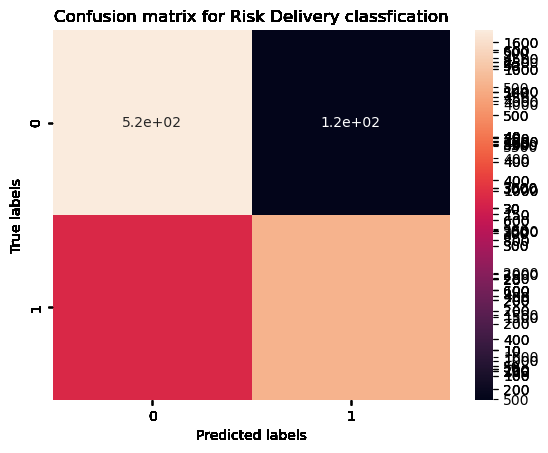

In [21]:
# Initialize models
models = model_utils.init_models(type='classification')
# Train models
model_utils.train_models(models, x_train_class, y_train_class)
# Evaluate models
preds = model_utils.predict(models, x_test_class)
acc,roc,rep = model_utils.eval_classification(y_true=y_test_class,preds=preds)
# Evaluate per order status
acc,roc,rep = model_utils.eval_per_order_status(x=x_test_class,y=y_test_class,models=models, type='classification')

Let's also try a Neural Network using all features (except for City, Country, Region...)

In [22]:
features_to_drop = ['^Order City_', '^Order Country_', '^Order Region_']
# features_to_drop = ['^Order City_', '^Order Country_', '^Order Region_', '^Profit on', '^Market','^Type','^Latitude','^Longitude','^order_']
# features_to_drop = ['^none']
simple_prep_data = prep_data.drop(prep_data.filter(regex='|'.join(features_to_drop)).columns, axis=1)
x_class = simple_prep_data.drop(['Late_delivery_risk', 'Days for shipping (real)'],axis=1)
y_class = simple_prep_data[['Late_delivery_risk']]
# train-test_split
x_train_class,x_test_class,y_train_class,y_test_class = model_selection.train_test_split(x_class,y_class,test_size=0.20,random_state=42,stratify=y_class)
# train-validation split
x_train_class,x_val_class,y_train_class,y_val_class = model_selection.train_test_split(x_train_class,y_train_class,test_size=0.25,random_state=42,stratify=y_train_class)

mlp_classifier_pipeline trained


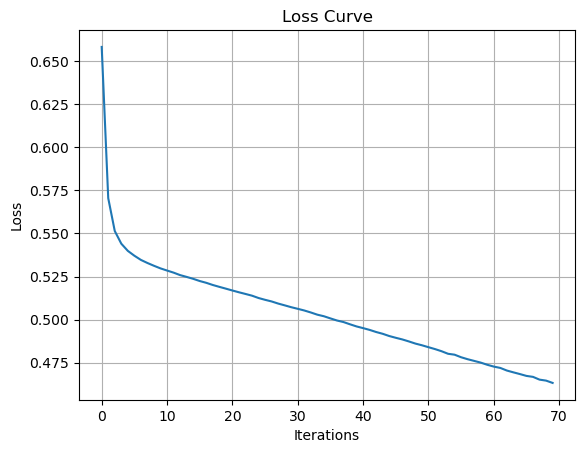

Accuracy for mlp_classifier_pipeline: 0.6884737678855326
ROC for mlp_classifier_pipeline: 0.705555986021897
Report for mlp_classifier_pipeline:               precision    recall  f1-score   support

           0       0.60      0.82      0.69      5370
           1       0.82      0.59      0.68      7210

    accuracy                           0.69     12580
   macro avg       0.71      0.71      0.69     12580
weighted avg       0.72      0.69      0.69     12580

Order Status: PENDING


EVALUATION OF mlp_classifier_pipeline
Accuracy for mlp_classifier_pipeline: 0.6864864864864865
ROC for mlp_classifier_pipeline: 0.6993154702244396
Report for mlp_classifier_pipeline:               precision    recall  f1-score   support

           0       0.61      0.80      0.69       646
           1       0.79      0.60      0.68       834

    accuracy                           0.69      1480
   macro avg       0.70      0.70      0.69      1480
weighted avg       0.71      0.69      0.69      1

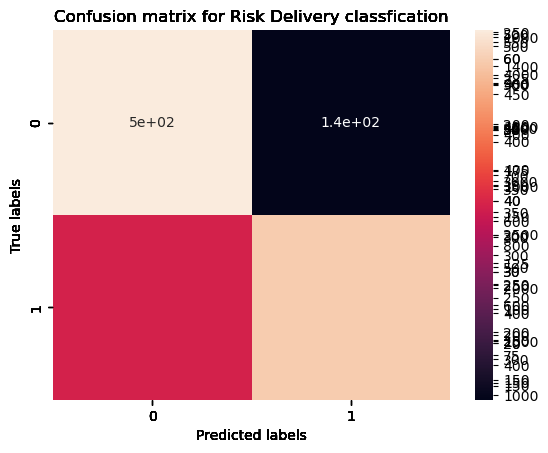

In [23]:
# Initialize models
nn_models = model_utils.init_nn(type='classification')
# Train models
model_utils.train_models(nn_models, x_train_class, y_train_class)
# Evaluate models
preds = model_utils.predict(nn_models, x_test_class)
acc,roc,rep = model_utils.eval_classification(y_true=y_test_class,preds=preds)
# Evaluate per order status
acc,roc,rep = model_utils.eval_per_order_status(x=x_test_class,y=y_test_class,models=nn_models, type='classification')

# 6) Regression

In [24]:
x_reg = prep_data.drop(['Late_delivery_risk', 'Days for shipping (real)'],axis=1)
y_reg = prep_data[['Days for shipping (real)']]
x_train_reg,x_test_reg,y_train_reg,y_test_reg = model_selection.train_test_split(x_reg,y_reg,test_size=0.20,random_state=42,stratify=y_reg)

In [25]:
# Initialize models
models = model_utils.init_models(type='regression')
# Train models
model_utils.train_models(models, x_train_reg, y_train_reg)
# Evaluate models
preds = model_utils.predict(models, x_test_reg)
acc,roc,rep = model_utils.eval_regression(y_true=y_test_reg,preds=preds)
# Evaluate per order status
acc,roc,rep = model_utils.eval_per_order_status(x=x_test_reg,y=y_test_reg,models=models, type='regression')

dt_regressor_pipeline trained
xgb_regressor_pipeline trained
R2 for dt_regressor_pipeline: -0.23704415127624534
MSE for dt_regressor_pipeline: 3.2614467408585055
MAE for dt_regressor_pipeline: 1.3083465818759936
R2 for xgb_regressor_pipeline: 0.38139941812160716
MSE for xgb_regressor_pipeline: 1.6309303508520632
MAE for xgb_regressor_pipeline: 1.003227890913696
Order Status: PENDING


EVALUATION OF dt_regressor_pipeline
R2 for dt_regressor_pipeline: -0.290446220805358
MSE for dt_regressor_pipeline: 3.36231884057971
MAE for dt_regressor_pipeline: 1.3429951690821256



Order Status: PROCESSING


EVALUATION OF dt_regressor_pipeline
R2 for dt_regressor_pipeline: -0.2641593009167347
MSE for dt_regressor_pipeline: 3.4030710172744723
MAE for dt_regressor_pipeline: 1.3493282149712091



Order Status: PENDING_PAYMENT


EVALUATION OF dt_regressor_pipeline
R2 for dt_regressor_pipeline: -0.21573810393997062
MSE for dt_regressor_pipeline: 3.2590443686006827
MAE for dt_regressor_pipeline: 1.31569965

# 6) Regression only important features

In [26]:
importance_df = model_utils.get_ft_importance(x=x_train_reg,model=models["xgb_regressor_pipeline"], type='regression')
importance_df

,Feature,Importance
0,Days for shipment (scheduled),0.208551
201,Profit on Children's heaters,0.010613
30,Order Country_Austria,0.009998
118,Order Country_Moldavia,0.008601
265,Profit on Rock music,0.008502
...,...,...
47,Order Country_Camboya,0.000000
50,Order Country_Chad,0.000000
53,Order Country_Chipre,0.000000
97,Order Country_Jamaica,0.000000


In [27]:
# Let's drop Order City, Order Country, and Order Region as they have minimal importance compared to their dimensionality
features = ['^Market','^Type','^Latitude','^Longitude','^Order Status','^order_','^Profit on']
# These are the features we will drop/keep depending on the performance of the model. We will definitely keep Shipping Mode, as it has the highest importance score
features_to_drop = ['^Order City_', '^Order Country_', '^Order Region_']
ft_performace_dict = model_utils.get_best_fts(models=models,prep_data=prep_data,features=features, features_to_drop=features_to_drop, type='regression')
ft_performace_dict

Model: dt_regressor_pipeline
Combination: ('^Market',)
Performance: 1.3182034976152623


Model: dt_regressor_pipeline
Combination: ('^Type',)
Performance: 1.3308426073131956


Model: dt_regressor_pipeline
Combination: ('^Latitude',)
Performance: 1.3089030206677266


Model: dt_regressor_pipeline
Combination: ('^Longitude',)
Performance: 1.3089030206677266


Model: dt_regressor_pipeline
Combination: ('^Order Status',)
Performance: 1.3065977742448331


Model: dt_regressor_pipeline
Combination: ('^order_',)
Performance: 1.3044515103338632


Model: dt_regressor_pipeline
Combination: ('^Profit on',)
Performance: 1.3082670906200318


Model: dt_regressor_pipeline
Combination: ('^Market', '^Type')
Performance: 1.3163751987281398


Model: dt_regressor_pipeline
Combination: ('^Market', '^Latitude')
Performance: 1.3135930047694753


Model: dt_regressor_pipeline
Combination: ('^Market', '^Longitude')
Performance: 1.344912559618442


Model: dt_regressor_pipeline
Combination: ('^Market', '^Order Stat

{'dt_regressor_pipeline': {('^Market', '^Longitude'): 1.344912559618442,
  ('^Market', '^Longitude', '^Order Status', '^order_'): 1.3330683624801272,
  ('^Type',): 1.3308426073131956,
  ('^Market', '^Type', '^Longitude'): 1.3302066772655008,
  ('^Market', '^Type', '^Order Status'): 1.325993640699523,
  ('^Market', '^Longitude', '^order_'): 1.3252782193958665,
  ('^Market', '^Type', '^Longitude', '^Order Status'): 1.324006359300477,
  ('^Type', '^Order Status'): 1.3216216216216217,
  ('^Market', '^Type', '^Latitude', '^Profit on'): 1.320952570217276,
  ('^Longitude', '^Order Status', '^order_'): 1.3208267090620032,
  ('^Market',
   '^Type',
   '^Longitude',
   '^Order Status',
   '^order_'): 1.3207472178060413,
  ('^Type', '^Latitude', '^Longitude', '^order_'): 1.3205967522143995,
  ('^Market', '^Type', '^Latitude', '^Order Status'): 1.3201510333863276,
  ('^Market', '^Latitude', '^Order Status', '^order_'): 1.31939586645469,
  ('^Latitude', '^Longitude', '^Order Status', '^order_'): 1.

Best feature combination (as in best performing + most simple): Shipping Mode, Days for shipping (scheduled), Order Status (Order Status can also be dropped, but let's keep it for explanatory reasons, also the performance is not influenced that much by adding/dropping it)

In [28]:
features_to_drop = ['^Market','^Type','^Latitude','^Longitude','^order_','^Profit on','^Order City_', '^Order Country_', '^Order Region_']

simple_prep_data = prep_data.drop(prep_data.filter(regex='|'.join(features_to_drop)).columns, axis=1)
x_reg = simple_prep_data.drop(['Late_delivery_risk', 'Days for shipping (real)'],axis=1)
y_reg = simple_prep_data[['Days for shipping (real)']]
# train-test_split
x_train_reg,x_test_reg,y_train_reg,y_test_reg = model_selection.train_test_split(x_reg,y_reg,test_size=0.20,random_state=42,stratify=y_reg)
# train-validation split
x_train_reg,x_val_reg,y_train_reg,y_val_reg = model_selection.train_test_split(x_train_reg,y_train_reg,test_size=0.25,random_state=42,stratify=y_train_reg)

In [29]:
# Initialize models
models = model_utils.init_models(type='regression')
# Train models
model_utils.train_models(models, x_train_reg, y_train_reg)
# Evaluate models
preds = model_utils.predict(models, x_test_reg)
acc,roc,rep = model_utils.eval_regression(y_true=y_test_reg,preds=preds)
# Evaluate per order status
acc,roc,rep = model_utils.eval_per_order_status(x=x_test_reg,y=y_test_reg,models=models, type='regression')

dt_regressor_pipeline trained
xgb_regressor_pipeline trained
R2 for dt_regressor_pipeline: 0.39220935543047775
MSE for dt_regressor_pipeline: 1.6024301273406163
MAE for dt_regressor_pipeline: 0.9814451310368316
R2 for xgb_regressor_pipeline: 0.3922101836125671
MSE for xgb_regressor_pipeline: 1.6024279438520375
MAE for xgb_regressor_pipeline: 0.9814436300878305
Order Status: PENDING


EVALUATION OF dt_regressor_pipeline
R2 for dt_regressor_pipeline: 0.3945526349385805
MSE for dt_regressor_pipeline: 1.5775218290421142
MAE for dt_regressor_pipeline: 0.9645241978691604



Order Status: PROCESSING


EVALUATION OF dt_regressor_pipeline
R2 for dt_regressor_pipeline: 0.37805612222680707
MSE for dt_regressor_pipeline: 1.6742503759505676
MAE for dt_regressor_pipeline: 1.019020054025081



Order Status: PENDING_PAYMENT


EVALUATION OF dt_regressor_pipeline
R2 for dt_regressor_pipeline: 0.38293574125388785
MSE for dt_regressor_pipeline: 1.654171890322334
MAE for dt_regressor_pipeline: 1.0029739228

Let's also try a NN

In [35]:
# features_to_drop = ['^Order City_', '^Order Country_', '^Order Region_']
# features_to_drop = ['^Order City_', '^Order Country_', '^Order Region_', '^Profit on', '^Market','^Type','^Latitude','^Longitude','^order_']
features_to_drop = ['^Market','^Type','^Latitude','^Longitude','^order_','^Profit on','^Order City_', '^Order Country_', '^Order Region_']
# features_to_drop = ['^none']
simple_prep_data = prep_data.drop(prep_data.filter(regex='|'.join(features_to_drop)).columns, axis=1)
x_reg = simple_prep_data.drop(['Late_delivery_risk', 'Days for shipping (real)'],axis=1)
y_reg = simple_prep_data[['Days for shipping (real)']]
# train-test_split
x_train_reg,x_test_reg,y_train_reg,y_test_reg = model_selection.train_test_split(x_reg,y_reg,test_size=0.20,random_state=42,stratify=y_reg)
# train-validation split
x_train_reg,x_val_reg,y_train_reg,y_val_reg = model_selection.train_test_split(x_train_reg,y_train_reg,test_size=0.25,random_state=42,stratify=y_train_reg)

mlp_regressor_pipeline trained


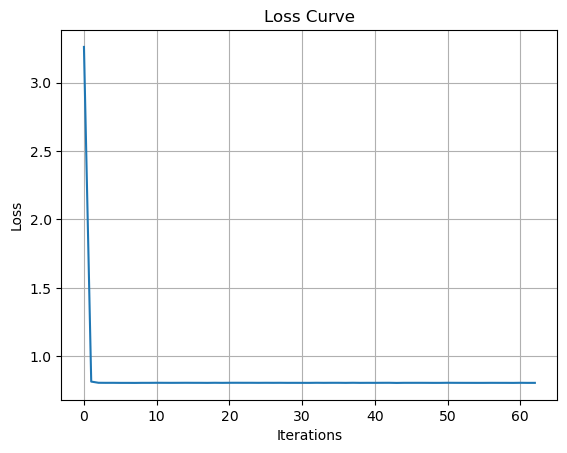

R2 for mlp_regressor_pipeline: 0.3914122819935474
MSE for mlp_regressor_pipeline: 1.6045315984646822
MAE for mlp_regressor_pipeline: 0.9917167608436116
Order Status: PENDING


EVALUATION OF mlp_regressor_pipeline
R2 for mlp_regressor_pipeline: 0.3937171391914519
MSE for mlp_regressor_pipeline: 1.5796987528429693
MAE for mlp_regressor_pipeline: 0.9743445392179548



Order Status: PROCESSING


EVALUATION OF mlp_regressor_pipeline
R2 for mlp_regressor_pipeline: 0.3755936481715343
MSE for mlp_regressor_pipeline: 1.6808792668523806
MAE for mlp_regressor_pipeline: 1.0337209867967807



Order Status: PENDING_PAYMENT


EVALUATION OF mlp_regressor_pipeline
R2 for mlp_regressor_pipeline: 0.38204252282162865
MSE for mlp_regressor_pipeline: 1.6565663521658431
MAE for mlp_regressor_pipeline: 1.016995918700577



Order Status: PAYMENT_REVIEW


EVALUATION OF mlp_regressor_pipeline
R2 for mlp_regressor_pipeline: 0.4554877386871691
MSE for mlp_regressor_pipeline: 1.5406577393656011
MAE for mlp_regresso

In [36]:
# Initialize models
nn_models = model_utils.init_nn(type='regression')
# Train models
model_utils.train_models(nn_models, x_train_reg, y_train_reg)
# Evaluate models
preds = model_utils.predict(nn_models, x_test_reg)
acc,roc,rep = model_utils.eval_regression(y_true=y_test_reg,preds=preds)
# Evaluate per order status
acc,roc,rep = model_utils.eval_per_order_status(x=x_test_reg,y=y_test_reg,models=nn_models, type='regression')